<a href="https://colab.research.google.com/github/TrevorIkky/Group-Task-ImageClassification/blob/main/Group_Task_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import typing
from tensorflow.keras.layers import (ZeroPadding2D, Input, Flatten, Dense, Add, Conv2D, MaxPool2D, BatchNormalization, Activation, AveragePooling2D)
from tensorflow.keras.layers.experimental.preprocessing import (Rescaling, Resizing)
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)
%tensorflow_version 2.x

In [ ]:
"""
Implementation of ResNet block
y -> input_tensor
output_channels-> output_channels

identity_mapping convert input_shape = (56, 56, 128)  to (28, 28, 256)
Stride for identity_mapping_conv layer results in o = 56 / 2 = 28
"""
@tf.function
def block(y: tf.Tensor, output_channels: int, stride: int = 1, identity_map: bool = False) -> tf.Tensor:
  x = Conv2D(output_channels, kernel_size= 1, strides=stride, padding='valid')(y)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(output_channels, kernel_size = 3, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(output_channels * 4, kernel_size= 1, strides=1, padding='valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  if identity_map:
    i = Conv2D(output_channels * 4, kernel_size=1, strides=stride, padding='valid')(y)
    x =  Add()([x, i])
  x = Activation('relu')(x)
  return x

In [ ]:
"""
  Implementation of ResNet:
  ResNet50 = [3, 4, 6, 3]
  ResNet101 = [3, 4, 23, 3]
  
  o=output, s=stride, p=padding
  output = [ (n + 2p - f + 1) / s ] 

  Conv: 7x7 o64, s2, p3 -> 112x112
  MaxPool: 3x3, o, s2 ->  55
"""
@tf.function
def ResNet(layers : typing.List[int] = [3, 4, 6, 3], input_shape : typing.Tuple[int] = (224, 224, 3), classes : int = 1) -> Model:
  channels = 64
  l = Input(shape=input_shape)
  s = Rescaling(1./255, input_shape=input_shape)(l)
  x = ZeroPadding2D((3, 3))(s)
  x = Conv2D(channels, kernel_size=7, strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
  c, x = make_layer(x, channels, layers[0], stride=1)
  c, x = make_layer(x, c, layers[1], stride=2)
  c, x = make_layer(x, c, layers[2],stride=2)
  c, x = make_layer(x, c, layers[3],stride=2)
  x = AveragePooling2D((2,2))(x)
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation('softmax')(x)
  model = Model(inputs=l, outputs=x)
  return model
  

In [ ]:
def make_layer(x, channels:int, multiplier:int, stride=1) -> (int, tf.Tensor):
  x = block(x, channels, stride, identity_map=True)
  for _ in range(0, (multiplier - 1)):
    x = block(x, channels)
  return (channels * 2), x  

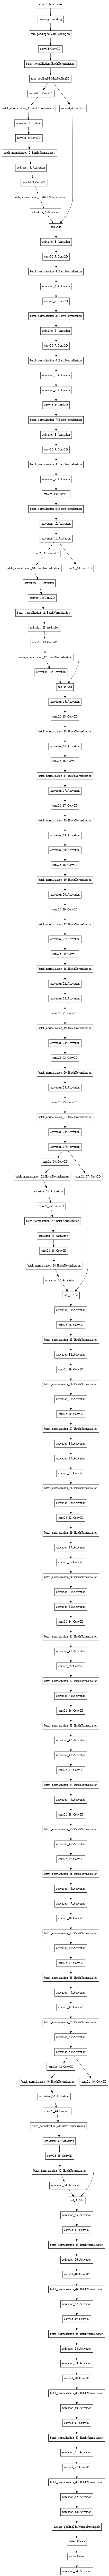

In [ ]:
model = ResNet(layers=[3, 4, 6, 3])
tf.keras.utils.plot_model(model, dpi=60)

# **Dataset**
The dataset is loaded from tensorflow datasets. <br>
The dataset consists of  colorectal cancer histology image textures  each having a label containing the texture type.


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
ds_train, info = tfds.load('colorectal_histology', split='train', shuffle_files=True, as_supervised=True, with_info=True)
assert isinstance(ds_train, tf.data.Dataset)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteM9CP29/colorectal_histology-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


tfds.core.DatasetInfo(
    name='colorectal_histology',
    version=2.0.0,
    description='Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    total_num_examples=5000,
    splits={
        'train': 5000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      y

Visualize the dataset & show texture types with their corresponding labels and integer class identifiers.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


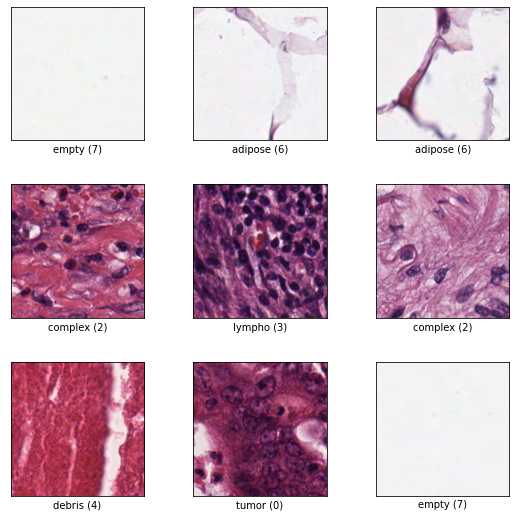

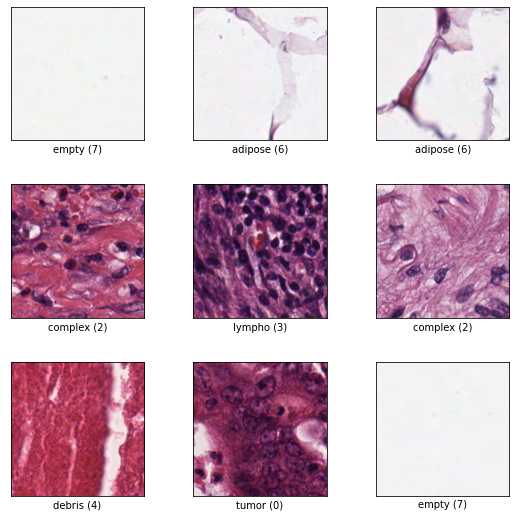

In [ ]:

tfds.show_examples(ds_train, info)

In [ ]:
labels = info.features['label']
for name in labels.names:
  print(f'Texture: {name} => Label id: {labels.str2int(name)}')

Texture: tumor => Label id: 0
Texture: stroma => Label id: 1
Texture: complex => Label id: 2
Texture: lympho => Label id: 3
Texture: debris => Label id: 4
Texture: mucosa => Label id: 5
Texture: adipose => Label id: 6
Texture: empty => Label id: 7


# **Split Dataset, Batch & Prefetch**
Get the dataset size = 5000<br>
Split the dataset to train, validation and test samples = 70/20/10<br>
Specify the batchsize to 64 (will be changed later to by Keras Tuner)<br>
Prefetch the dataset, let Tensorflow decide the number to prefetch using tf.data.AUTOTUNE

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
HISTOLOGY_CLASSES = len(info.features['label'].names)

num_train = ds_train.cardinality().numpy()

ds_train_size =  num_train * 0.7
ds_val_size = num_train * 0.2
ds_test_size = num_train * 0.1 

X_train = ds_train.take(ds_train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
X_val = ds_train.skip(ds_train_size).take(ds_val_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
X_test = ds_train.skip(ds_train_size + ds_val_size).take(ds_test_size)

print(f'Total number of examples: {num_train}')
print(f'Train/Val/Test => {ds_train_size}/{ds_val_size}/{ds_test_size}\n\n')


for (img1, label1) in ds_train.take(1):
  INPUT_SHAPE = img1.shape
  print(f'Image shape: {img1.shape}')

Total number of examples: 5000
Train/Val/Test => 3500.0/1000.0/500.0


Image shape: (150, 150, 3)


# **Initialize ResNet50 Model**
Number of classes to predict = 8 (Multi-class classification)<br>
Use 2 callbacks: EarlyStopping & ModelCheckpoint to stop the model training when loss is not improving and save best model during training time respectively<br>

Optimizer: SGD (Requires experimentation maybe will change to Adam)<br>
Loss: SparseCategoricalCrossentropy (Since we are not providing texture labels as one hot encodings, but integers representing the class of the textures)<br>
Using accuracy as the metric to keep track of the predictions the model got right vs the total number of predictions $Accuracy = P_c / P_t$


In [ ]:
colorectal_histology_model = ResNet(layers=[3, 4, 6, 3], input_shape=INPUT_SHAPE, classes = HISTOLOGY_CLASSES)

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stopping = EarlyStopping(patience=2, monitor='loss')
checkpoint = ModelCheckpoint("colorectal_histology_model", save_best_only=True)
colorectal_histology_model.compile(optimizer=SGD(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = colorectal_histology_model.fit(X_train, validation_data=X_val, batch_size=BATCH_SIZE, epochs=15, callbacks=[early_stopping, checkpoint])

Epoch 1/15
55/55 [==============================] - 82s 952ms/step - loss: 1.7777 - accuracy: 0.3540 - val_loss: 14.8203 - val_accuracy: 0.1310
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
55/55 [==============================] - 51s 921ms/step - loss: 1.1303 - accuracy: 0.5720 - val_loss: 7.6604 - val_accuracy: 0.0640
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
55/55 [==============================] - 51s 920ms/step - loss: 0.8622 - accuracy: 0.6809 - val_loss: 7.3998 - val_accuracy: 0.1140
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
55/55 [==============================] - 51s 927ms/step - loss: 0.7247 - accuracy: 0.7389 - val_loss: 9.8859 - val_accuracy: 0.1280
Epoch 5/15
55/55 [==============================] - 51s 919ms/step - loss: 0.6631 - accuracy: 0.7540 - val_loss: 3.1421 - val_accuracy: 0.1460
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
55/55 [==============================] - 51s 919ms/step - loss: 0.5642 - accuracy: 0.7886 - val_loss: 2.0257 - val_accuracy: 0.3830
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
55/55 [==============================] - 51s 932ms/step - loss: 0.5189 - accuracy: 0.8080 - val_loss: 1.4905 - val_accuracy: 0.5590
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
55/55 [==============================] - 51s 919ms/step - loss: 0.4862 - accuracy: 0.8191 - val_loss: 0.7092 - val_accuracy: 0.7200
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
55/55 [==============================] - 51s 927ms/step - loss: 0.4183 - accuracy: 0.8489 - val_loss: 0.5571 - val_accuracy: 0.7950
INFO:tensorflow:Assets written to: colorectal_histology_model/assets


INFO:tensorflow:Assets written to: colorectal_histology_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
55/55 [==============================] - 51s 920ms/step - loss: 0.3798 - accuracy: 0.8577 - val_loss: 0.6674 - val_accuracy: 0.7540
Epoch 11/15
55/55 [==============================] - 50s 917ms/step - loss: 0.4028 - accuracy: 0.8511 - val_loss: 0.7970 - val_accuracy: 0.7460
Epoch 12/15
55/55 [==============================] - 50s 917ms/step - loss: 0.3258 - accuracy: 0.8806 - val_loss: 0.6607 - val_accuracy: 0.7650
Epoch 13/15
55/55 [==============================] - 50s 918ms/step - loss: 0.3584 - accuracy: 0.8714 - val_loss: 0.6175 - val_accuracy: 0.7970
Epoch 14/15
55/55 [==============================] - 50s 916ms/step - loss: 0.3098 - accuracy: 0.8851 - val_loss: 0.7621 - val_accuracy: 0.7510
Epoch 15/15
55/55 [==============================] - 51s 924ms/step - loss: 0.2730 - accuracy: 0.9017 - val_loss: 0.5800 - val_accuracy: 0.8010


# **Plot Metric Graphs**
Plot graphs of metrics e.g. loss against accuracy or loss against validation accuracy to see the progression of these metrics accross different epochs.<br>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [ ]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.777730,0.354000,14.820290,0.131
1,1.130347,0.572000,7.660406,0.064
2,0.862154,0.680857,7.399843,0.114
3,0.724703,0.738857,9.885947,0.128
4,0.663116,0.754000,3.142149,0.146


Text(0.5, 0, 'Epochs')

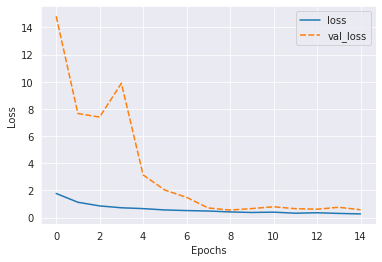

In [ ]:
sns.lineplot(data=[df_history["loss"], df_history["val_loss"]])
plt.ylabel("Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

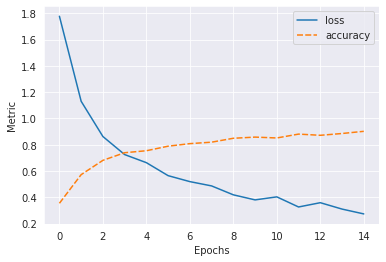

In [ ]:
sns.lineplot(data =[df_history['loss'], df_history['accuracy']])
plt.ylabel("Metric")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

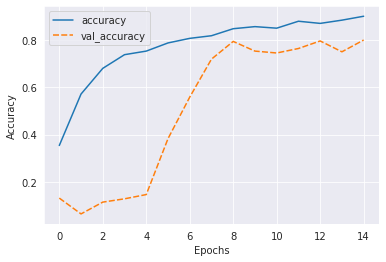

In [ ]:
sns.lineplot(data =[df_history['accuracy'], df_history['val_accuracy']])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

# **Test model prediction**

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
best_histology_model = load_model("colorectal_histology_model")

In [ ]:
Xp_test = X_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)
prediction = best_histology_model.predict(Xp_test)

In [ ]:
idx = 0
for (tImage, tLabel) in X_test.take(5):
  print(f'True: {tLabel.numpy()}, Pred: {np.argmax(prediction[idx])}')
  idx+=1

True: 1, Pred: 1
True: 5, Pred: 5
True: 7, Pred: 7
True: 7, Pred: 7
True: 6, Pred: 7


# **Hyperparameter Tuning**

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 3.3 MB/s 


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# **Hyperparameters to Tune**
Number of blocks in each layer in ResNet <br>
Changing the learning rate or momentum of the optimizer, will change the optimizer to Adam <br>
Finding the optimal batch size to feed the model.<br>


In [ ]:
def build_model(hp) -> Model:
  histology_model = ResNet(layers=[3, 4, 6, 3], input_shape=INPUT_SHAPE, classes = HISTOLOGY_CLASSES)
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  histology_model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
  return histology_model

In [ ]:
kt_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3,
                     directory='/content', project_name='kt_histology_model')

tuner.search(X_train, validation_data=X_val, epochs=30, callbacks=[kt_early_stopping])

Trial 3 Complete [00h 01m 43s]
val_accuracy: 0.13099999725818634

Best val_accuracy So Far: 0.13099999725818634
Total elapsed time: 00h 05m 41s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit
